In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
folder = "data/ADHD_part1"
file_name = os.listdir(folder)[0]

print("File:", file_name)

mat = loadmat(os.path.join(folder, file_name))
print(mat.keys())


File: v10p.mat
dict_keys(['__header__', '__version__', '__globals__', 'v10p'])


In [3]:
key = file_name.replace(".mat", "")
eeg = mat[key]

print("Original shape:", eeg.shape)


Original shape: (14304, 19)


In [4]:
eeg = eeg.T
print("Correct shape:", eeg.shape)


Correct shape: (19, 14304)


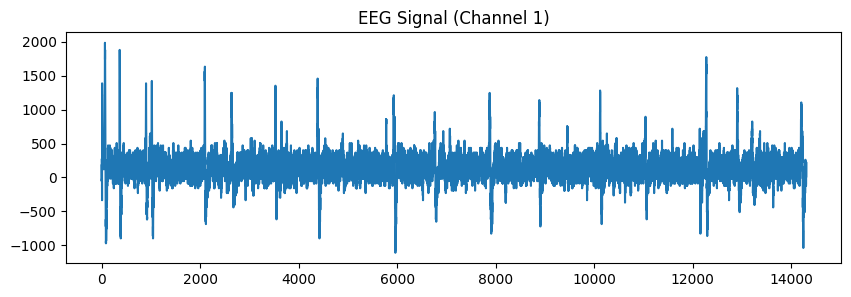

In [5]:
plt.figure(figsize=(10,3))
plt.plot(eeg[0])
plt.title("EEG Signal (Channel 1)")
plt.show()

In [6]:
WINDOW_SIZE = 256   # 2 seconds (128 Hz)
STEP_SIZE = 128     # 50% overlap

In [7]:
def create_windows(eeg, window_size, step_size):
    windows = []
    for i in range(0, eeg.shape[1] - window_size, step_size):
        windows.append(eeg[:, i:i+window_size])
    return np.array(windows)

In [8]:
windows = create_windows(eeg, WINDOW_SIZE, STEP_SIZE)
print("Windows shape:", windows.shape)

Windows shape: (110, 19, 256)


In [9]:
def load_folder(folder_path, label):
    X = []
    y = []

    for file in os.listdir(folder_path):
        if file.endswith(".mat"):
            mat = loadmat(os.path.join(folder_path, file))
            key = file.replace(".mat", "")
            eeg = mat[key]

            if eeg.shape[1] == 19:
                eeg = eeg.T

            windows = create_windows(eeg, WINDOW_SIZE, STEP_SIZE)
            X.append(windows)
            y.extend([label] * len(windows))

    return np.concatenate(X), np.array(y)

In [10]:
X_adhd1, y_adhd1 = load_folder("data/ADHD_part1", 0)
X_adhd2, y_adhd2 = load_folder("data/ADHD_part2", 0)

X_ctrl1, y_ctrl1 = load_folder("data/Control_part1", 1)
X_ctrl2, y_ctrl2 = load_folder("data/Control_part2", 1)

X = np.concatenate([X_adhd1, X_adhd2, X_ctrl1, X_ctrl2])
y = np.concatenate([y_adhd1, y_adhd2, y_ctrl1, y_ctrl2])

print("EEG samples:", X.shape)
print("Labels:", y.shape)


EEG samples: (16748, 19, 256)
Labels: (16748,)


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(X.shape)


In [12]:
X_cnn = X_scaled[..., np.newaxis]
print("CNN input shape:", X_cnn.shape)

CNN input shape: (16748, 19, 256, 1)


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y, test_size=0.2, random_state=42
)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(19,256,1)),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


C:\Users\ojesh_hpnmmdy\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\ojesh_hpnmmdy\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\ojesh_hpnmmdy\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resour

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 17, 254, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 127, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 6, 125, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 62, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5952)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       380,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 385,857 (1.47 MB)

 Trainable params: 385,857 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7821 - loss: 0.4613 - val_accuracy: 0.8922 - val_loss: 0.2748
Epoch 2/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9127 - loss: 0.2245 - val_accuracy: 0.9313 - val_loss: 0.1825
Epoch 3/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9540 - loss: 0.1267 - val_accuracy: 0.9705 - val_loss: 0.1149
Epoch 4/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9761 - loss: 0.0755 - val_accuracy: 0.9795 - val_loss: 0.0779
Epoch 5/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9894 - loss: 0.0365 - val_accuracy: 0.9862 - val_loss: 0.0716
Epoch 6/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9924 - loss: 0.0256 - val_accuracy: 0.9836 - val_loss: 0.0901
Epoch 7/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9966 - loss: 0.0138 - val_accuracy: 0.9944 - val_loss: 0.0521
Epoch 8/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9954 - loss: 0.0149 - val_accu

In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print("Final Test Accuracy:", round(test_acc * 100, 2), "%")


Final Test Accuracy: 99.49 %


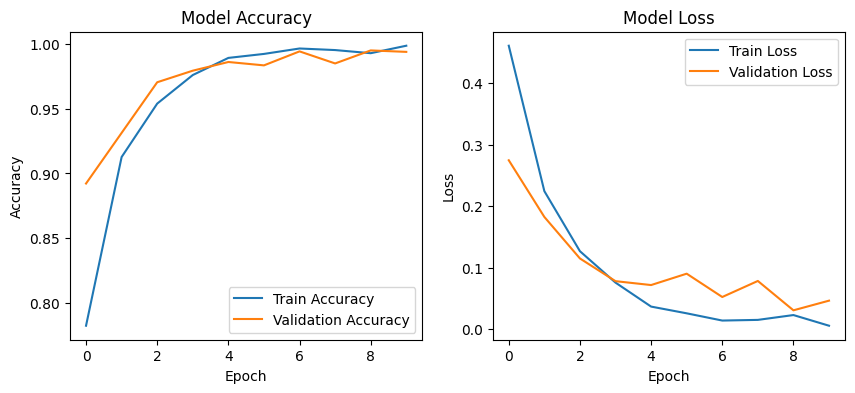

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()

plt.show()


In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict on test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=["ADHD", "Control"]
))


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Confusion Matrix:
[[1892    6]
 [  11 1441]]

Classification Report:
              precision    recall  f1-score   support

        ADHD       0.99      1.00      1.00      1898
     Control       1.00      0.99      0.99      1452

    accuracy                           0.99      3350
   macro avg       1.00      0.99      0.99      3350
weighted avg       0.99      0.99      0.99      3350



In [18]:
idx = 0  # any index
sample = X_test[idx:idx+1]
prediction = model.predict(sample)[0][0]

print("Prediction value:", prediction)

if prediction < 0.5:
    print("Model Prediction: ADHD")
else:
    print("Model Prediction: Control")

print("True Label:", "ADHD" if y_test[idx] == 0 else "Control")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Prediction value: 0.0001946425
Model Prediction: ADHD
True Label: ADHD


In [19]:
pred = model.predict(sample)[0][0]

print("Prediction value:", pred)

if pred < 0.5:
    print("Model Prediction: ADHD")
else:
    print("Model Prediction: Control")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction value: 0.0001946425
Model Prediction: ADHD


In [20]:
import tensorflow as tf
import numpy as np

def grad_cam(model, input_data, layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[
            model.get_layer(layer_name).output,
            model.outputs[0]
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(input_data)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8

    return heatmap.numpy()


In [21]:
# force model call
_ = model(sample)

heatmap = grad_cam(model, sample, "conv2d_1")
print("Heatmap shape:", heatmap.shape)


Heatmap shape: (6, 125)


C:\Users\ojesh_hpnmmdy\AppData\Roaming\Python\Python313\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 19, 256, 1))
  warnings.warn(msg)


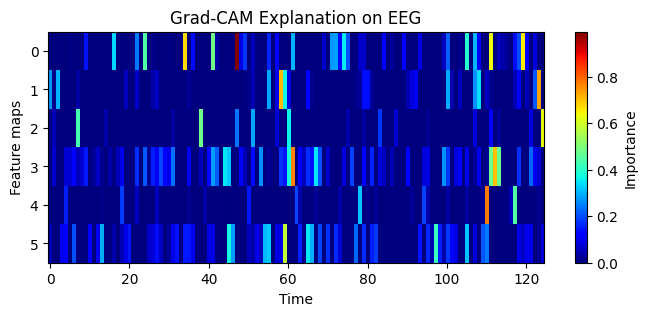

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,3))
plt.imshow(heatmap, aspect='auto', cmap='jet')
plt.colorbar(label="Importance")
plt.xlabel("Time")
plt.ylabel("Feature maps")
plt.title("Grad-CAM Explanation on EEG")
plt.show()


In [23]:
model.save("model.h5")

In [24]:
import joblib
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']